In [1]:
!pip install ipython-autotime

%load_ext autotime

time: 2.57 ms (started: 2021-03-31 15:56:14 +00:00)


## **3. LSTM 모델 활용하기**

앞서 살펴본 LSTM 레이어를 이용하여 몇가지 순환 신경망 모델을 만들어보고, 각 모델에 "나비야" 동요를 학습시켜보면서 자세히 살펴보겠습니다.

---

### *시퀀스 데이터 준비*

순환 신경망은 주로 자연어 처리에 많이 쓰이기 때문에 문장 학습 예제가 일반적이지만 본 강좌에서는 악보 학습을 해보겠습니다. 그 이유는 
- 음계가 문장보다 더 코드화 하기 쉽고, 
- 시계열 자료이며, 
- 나온 결과를 악보로 볼 수 있으며,
- 무엇보다 우리가 학습한 모델이 연주하는 곡을 들어볼 수 있기 때문입니다. 
일단 쉬운 악보인 '나비야'를 준비했습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_2.png)

음표 밑에 간단한 음표코드를 표시하였습니다. 알파벳은 음계를 나타내며, 숫자는 음의 길이를 나타냅니다.
- c(도), d(레), e(미), f(파), g(솔), a(라), b(시)
- 4(4분음표), 8(8분음표)

---

### *데이터셋 생성*

먼저 두 마디만 살펴보겠습니다. 

* g8 e8 e4
* f8 d8 d4 

여기서 우리가 정의한 문제대로 4개 음표 입력으로 다음 출력 음표를 예측하려면, 아래와 같이 데이터셋을 구성합니다.

* g8 e8 e4 f8 **d8** : 1~4번째 음표, **5번째** 음표
* e8 e4 f8 d8 **d4** : 2~5번째 음표, **6번째** 음표

6개의 음표로는 위와 같이 2개의 샘플이 나옵니다. 각 샘플은 4개의 입력 데이터와 1개의 라벨값으로 구성되어 있습니다. 즉 1~4번째 열은 속성(feature)이고, 5번째 열은 클래스(class)를 나타냅니다. 이렇게 4개씩 구간을 보는 것을 윈도우 크기가 4라고 합니다. 그리고 문자와 숫자로 된 음표(코드)로는 모델 입출력으로 사용할 수 없기 때문에 각 코드를 숫자로 변환할 수 있는 사전을 하나 만들어봅니다. 첫번째 사전은 코드를 숫자로, 두번째 사전은 숫자를 코드로 만드는 코드입니다.

In [ ]:
code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

time: 3.9 ms (started: 2021-03-27 15:33:59 +00:00)


이러한 사전을 이용해서 순차적인 음표를 우리가 지정한 윈도우 크기만큼 잘라 데이터셋을 생성하는 함수를 정의해보겠습니다.

In [ ]:
import numpy as np

def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

time: 2.41 ms (started: 2021-03-27 15:34:00 +00:00)


seq라는 변수에 "나비야" 곡 전체 음표를 저장한 다음, seq2dataset() 함수를 하여 dataset를 생성합니다. 데이터셋은 앞서 정의한 사전에 따라 숫자로 변환되어 생성됩니다.

In [ ]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]
time: 44.5 ms (started: 2021-03-27 15:34:01 +00:00)


---

### *학습 과정*

"나비야"노래는 우리에게 너무나 익숙한 노래입니다. 만약 옆사람이 "나비야~ 나"까지만 불러도 나머지를 이어서 다 부를 수 있을 정도로 말이죠. 이렇게 첫 4개 음표를 입력하면 나머지를 연주할 수 있는 모델을 만드는 것이 목표입니다. 우리가 정의한 문제를 풀기 위해 먼저 모델을 학습시켜야 합니다. 학습 시키는 방식은 아래와 같습니다.

- 파란색 박스가 입력값이고, 빨간색 박스가 우리가 원하는 출력값입니다. 
- 1~4번째 음표를 데이터로 5번째 음표를 라벨값으로 학습을 시킵니다.
- 다음에는 2~5번째 음표를 데이터로 6번째 음표를 라벨값으로 학습을 시킵니다.
- 이후 한 음표씩 넘어가면서 노래 끝까지 학습시킵니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_5.png)

---
### *예측 과정*

예측은 두 가지 방법으로 해보겠습니다. `한 스텝 예측`과 `곡 전체 예측`입니다. 


#### 한 스텝 예측

한 스텝 예측이란 실제 음표 4개를 입력하여 다음 음표 1개를 예측하는 것을 반복하는 것입니다. 이 방법에서는 모델의 입력값으로는 항상 실제 음표가 들어갑니다.
- 모델에 t0, t1, t2, t3를 입력하면 y0 출력이 나옵니다. 
- 모델에 t1, t2, t3, t4를 입력하면 y1 출력이 나옵니다.
- 모델에 t2, t3, t4, t5를 입력하면 y2 출력이 나옵니다.
- 이 과정을 y49 출력까지 반복합니다. 

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_6.png)

#### 곡 전체 예측

곡 전체 예측이란 입력된 초가 4개 음표만을 입력으로 곡 전체를 예측하는 것입니다. 초반부가 지나면, 예측값만으로 모델에 입력되어 다음 예측값이 나오는 식입니다. 그야말로 "나비야~ 나"까지 알려주면 나머지까지 모두 연주를 하는 것이죠. 만약 중간에 틀린 부분이 생긴다면, 이후 음정, 박자는 모두 이상하게 될 가능성이 많습니다. 예측 오류가 누적되는 것이겠죠.

- 모델에 t0, t1, t2, t3를 입력하면 y0 출력이 나옵니다.
- 예측값인 y0를 t4라고 가정하고, 모델에 t1, t2, t3, t4을 입력하면 y1 출력이 나옵니다.
- 예측값인 y1을 t5라고 가정하고, 모델에 t2, t3, t4(예측값), t5(예측값)을 입력하면 y2 출력이 나옵니다.
- 이 과정을 y49 출력까지 반복합니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_7.png)

---

### *다층 퍼셉트론 모델*

앞서 생성한 데이터셋으로 먼저 다층 퍼셉트론 모델을 학습시켜보겠습니다. Dense 레이어 3개로 구성하였고, 입력 속성이 4개이고 출력이 12개(one_hot_vec_size=12)으로 설정했습니다.

In [ ]:
# 0. 사용할 패키지 불러오기
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(5)

time: 1.29 s (started: 2021-03-27 15:35:29 +00:00)


In [ ]:
one_hot_vec_size = len(code2idx)

model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(one_hot_vec_size, activation='softmax'))

time: 652 ms (started: 2021-03-27 15:35:31 +00:00)


"나비야" 악보를 이 모델을 학습할 경우 다음 그림과 같이 수행됩니다. 4개의 음표를 입력으로 받고, 그 다음 음표가 라벨값으로 지정됩니다. 이 과정을 곡이 마칠 때까지 반복하게 됩니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_train_MLP.png)

#### 소스코드

전체 소스는 다음과 같습니다.

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]
one hot encoding vector size is  12
Epoch 1/2000
5/5 - 1s - loss: 2.4486 - accuracy: 0.0600

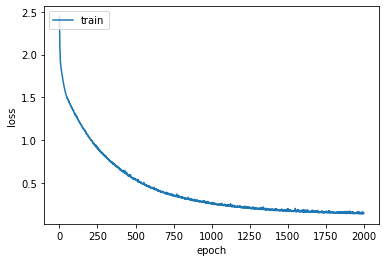

2/2 [==============================] - 0s 6ms/step - loss: 0.1381 - accuracy: 0.9200
accuracy: 92.00%
one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'g4', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'f8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8']
time: 31.5 s (started: 2021-03-27 15:35:37 +00:00)


In [ ]:
# 0. 사용할 패키지 불러오기
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수        
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

# 1. 데이터 준비하기

# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기
dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4)) # batch_size, feature
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

한 스텝 예측 결과와 곡 전체 예측 결과를 악보로 그려보았습니다. 이 중 틀린 부분을 빨간색 박스로 표시해봤습니다. 총 50개 예측 중 4개가 틀려서 92%의 정확도가 나왔습니다. 중간에 틀린 부분이 생기면 곡 전체를 예측하는 데 있어서는 그리 좋은 성능이 나오지 않습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_MLP_song.png)

위 악보로 연주한 곡은 아래 링크에서 다운로드 받으실 수 있습니다.

* [http://tykimos.github.io/warehouse/2017-4-9-MLP_one_step_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-MLP_one_step_prediction.mp3)
* [http://tykimos.github.io/warehouse/2017-4-9-MLP_full_song_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-MLP_full_song_prediction.mp3)

---

### *기본 LSTM 모델*

이번에는 간단한 기본 LSTM 모델로 먼저 테스트를 해보겠습니다. 모델 구성은 다음과 같이 하였습니다.
- 128 메모리 셀을 가진 LSTM 레이어 1개와 Dense 레이어로 구성
- 입력은 샘플이 50개, 타임스텝이 4개, 속성이 1개로 구성
- 상태유지(stateful) 모드 비활성화

케라스에서는 아래와 같이 LSTM을 구성할 수 있습니다.

In [ ]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

time: 2.3 ms (started: 2021-03-27 15:37:54 +00:00)


In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape = (4, 1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))

time: 229 ms (started: 2021-03-27 15:37:56 +00:00)


LSTM을 제대로 활용하기 위해서는 `상태유지 모드`, `배치사이즈`, `타임스텝`, `속성`에 대한 개념에 이해가 필요합니다. 본 절에서는 `타임스텝`에 대해서 먼저 알아보겠습니다. `타임스텝`이란 하나의 샘플에 포함된 시퀀스 개수입니다. 이는 앞서 살펴본 "input_length"와 동일합니다. 현재 문제에서는 매 샘플마다 4개의 값을 입력하므로 타임스텝이 4개로 지정할 수 있습니다. 즉 윈도우 크기와 동일하게 타임스텝으로 설정하면 됩니다. `속성`에 대해서는 나중에 알아보겠지만, 입력되는 음표 1개당 하나의 인덱스 값을 입력하므로 속성이 1개입니다. 나중에 이 `속성`의 개수를 다르게 해서 테스트 해보겠습니다. 인자로 "input_shape = (4, 1)'과 "input_dim = 1, input_length = 4"는 동일합니다. 설정한 LSTM 모델에 따라 입력할 데이터셋도 샘플 수, 타임스텝 수, 속성 수 형식으로 맞추어야 합니다. 따라서 앞서 구성한 x_train를 아래와 같이 형식을 변환합니다.

In [ ]:
x_train = np.reshape(x_train, (50, 4, 1)) # 샘플 수, 타임스텝 수, 속성 수

time: 1.11 ms (started: 2021-03-27 15:38:01 +00:00)


이 모델로 악보를 학습할 경우, 다층 퍼셉트론 모델과 동일하게 4개의 음표를 입력으로 받고, 그 다음 음표가 라벨값으로 지정됩니다. 이 과정을 곡이 마칠 때까지 반복하게 됩니다. 다층 퍼셉트론 모델과 차이점이 있다면, 다층 퍼셉트론 모델에서는 4개의 음표가 4개의 속성으로 입력되고, LSTM에서는 4개의 음표가 4개의 시퀀스 입력으로 들어갑니다. 여기서 속성은 1개입니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_train_LSTM.png)

#### 소스코드

전체 소스는 다음과 같습니다.

(50, 5)
one hot encoding vector size is  12
Epoch 1/2000
4/4 - 2s - loss: 2.4742 - accuracy: 0.0600
Epoch 2/2000
4/4 - 0s - loss: 2.4333 - accuracy: 0.2400
Epoch 3/2000
4/4 - 0s - loss: 2.3922 - accuracy: 0.3400
Epoch 4/2000
4/4 - 0s - loss: 2.3504 - accuracy: 0.3400
Epoch 5/2000
4/4 - 0s - loss: 2.3027 - accuracy: 0.3400
Epoch 6/2000
4/4 - 0s - loss: 2.2360 - accuracy: 0.3400
Epoch 7/2000
4/4 - 0s - loss: 2.1540 - accuracy: 0.3400
Epoch 8/2000
4/4 - 0s - loss: 2.0656 - accuracy: 0.3400
Epoch 9/2000
4/4 - 0s - loss: 2.0015 - accuracy: 0.3400
Epoch 10/2000
4/4 - 0s - loss: 1.9725 - accuracy: 0.3400
Epoch 11/2000
4/4 - 0s - loss: 1.9676 - accuracy: 0.3400
Epoch 12/2000
4/4 - 0s - loss: 1.9536 - accuracy: 0.3400
Epoch 13/2000
4/4 - 0s - loss: 1.9314 - accuracy: 0.3400
Epoch 14/2000
4/4 - 0s - loss: 1.9254 - accuracy: 0.3400
Epoch 15/2000
4/4 - 0s - loss: 1.9218 - accuracy: 0.3400
Epoch 16/2000
4/4 - 0s - loss: 1.9206 - accuracy: 0.3400
Epoch 17/2000
4/4 - 0s - loss: 1.9172 - accuracy: 0.3

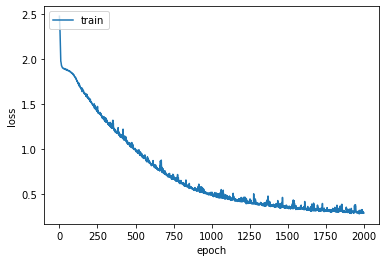

2/2 [==============================] - 0s 7ms/step - loss: 0.2854 - accuracy: 0.8600
accuracy: 86.00%
one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'e8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'e8', 'e8', 'e8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'e8', 'd4', 'c8', 'd8', 'd8', 'f8', 'g8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8']
time: 41.9 s (started: 2021-03-27 15:38:04 +00:00)


In [ ]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

# 1. 데이터 준비하기
        
# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)

# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타입스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50, 4, 1))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, input_shape = (4, 1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=14, verbose=2, callbacks=[history])

# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

한 스텝 예측 결과와 곡 전체 예측 결과를 악보로 그려보았습니다. 이 중 틀린 부분을 빨간색 박스로 표시해봤습니다. 총 50개 예측 중 4개가 틀려서 92%의 정확도가 나왔습니다. 중간에 틀릭 부분이 생기면 곡 전체를 예측하는 데 있어서는 그리 좋은 성능이 나오지 않습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_LSTM_song.png)

위 악보로 연주한 곡은 아래 링크에서 다운로드 받으실 수 있습니다.

* [http://tykimos.github.io/warehouse/2017-4-9-Stateless_LSTM_one_step_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-Stateless_LSTM_one_step_prediction.mp3)
* [http://tykimos.github.io/warehouse/2017-4-9-Stateless_LSTM_full_song_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-Stateless_LSTM_full_song_prediction.mp3)

---

### *상태유지 LSTM 모델*

이번에는 상태유지(Stateful) LSTM 모델에 대해서 알아보겠습니다. 여기서 `상태유지`라는 것은 현재 학습된 상태가 다음 학습 시 초기 상태로 전달된다는 것을 의미합니다. 

    상태유지 모드에서는 현재 샘플의 학습 상태가 다음 샘플의 초기 상태로 전달된다.
    
긴 시퀀드 데이터를 처리할 때, LSTM 모델은 상태유지 모드에서 그 진가를 발휘합니다. 긴 시퀀스 데이터를 샘플 단위로 잘라서 학습하더라도 LSTM 내부적으로 기억할 것은 기억하고 버릴 것은 버려서 기억해야할 중요한 정보만 이어갈 수 있도록 상태가 유지되기 때문입니다. 상태유지 LSTM 모델을 생성하기 위해서는 LSTM 레이어 생성 시, stateful=True로 설정하면 됩니다. 또한 상태유지 모드에서는 입력형태를 batch_input_shape = (배치사이즈, 타임스텝, 속성)으로 설정해야 합니다. 상태유지 모드에서 배치사이즈 개념은 조금 어려우므로 다음 장에서 다루기로 하겠습니다. 

In [ ]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

time: 3.02 ms (started: 2021-03-27 15:38:57 +00:00)


In [ ]:
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 1), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))

time: 221 ms (started: 2021-03-27 15:38:57 +00:00)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 10.3 ms (started: 2021-03-27 15:39:48 +00:00)


상태유지 모드에서는 모델 학습 시에 `상태 초기화`에 대한 고민이 필요합니다. 현재 샘플 학습 상태가 다음 샘플 학습의 초기상태로 전달되는 식인데, 현재 샘플과 다음 샘플 간의 순차적인 관계가 없을 경우에는 상태가 유지되지 않고 초기화가 되어야 합니다. 다음 상황이 이러한 경우에 해당됩니다.

- 마지막 샘플 학습이 마치고, 새로운 에포크 수행 시에는 새로운 샘플 학습을 해야하므로 상태 초기화 필요
- 한 에포크 안에 여러 시퀀스 데이터 세트가 있을 경우, 새로운 시퀀스 데이터 세트를 학습 전에 상태 초기화 필요

현재 코드에서는 한 곡을 가지고 계속 학습을 시키고 있으므로 새로운 에포크 시작 시에만 상태 초기화를 수행하면 됩니다.

In [ ]:
num_epochs = 2000

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False) # 50 is X.shape[0]
    model.reset_states()

epochs : 0
50/50 - 1s - loss: 2.3327 - accuracy: 0.2800
epochs : 1
50/50 - 0s - loss: 2.0224 - accuracy: 0.3400
epochs : 2
50/50 - 0s - loss: 1.9590 - accuracy: 0.3400
epochs : 3
50/50 - 0s - loss: 1.9427 - accuracy: 0.3400
epochs : 4
50/50 - 0s - loss: 1.9328 - accuracy: 0.3400
epochs : 5
50/50 - 0s - loss: 1.9260 - accuracy: 0.3400
epochs : 6
50/50 - 0s - loss: 1.9207 - accuracy: 0.3400
epochs : 7
50/50 - 0s - loss: 1.9163 - accuracy: 0.3400
epochs : 8
50/50 - 0s - loss: 1.9125 - accuracy: 0.3400
epochs : 9
50/50 - 0s - loss: 1.9090 - accuracy: 0.3600
epochs : 10
50/50 - 0s - loss: 1.9055 - accuracy: 0.3600
epochs : 11
50/50 - 0s - loss: 1.9019 - accuracy: 0.3600
epochs : 12
50/50 - 0s - loss: 1.8976 - accuracy: 0.3600
epochs : 13
50/50 - 0s - loss: 1.8917 - accuracy: 0.3600
epochs : 14
50/50 - 0s - loss: 1.9095 - accuracy: 0.3600
epochs : 15
50/50 - 0s - loss: 1.8944 - accuracy: 0.3600
epochs : 16
50/50 - 0s - loss: 1.8841 - accuracy: 0.3600
epochs : 17
50/50 - 0s - loss: 1.8710 - a

아래 그림은 이 모델로 악보를 학습할 경우를 나타낸 것입니다. 거의 기본 LSTM 모델과 동일하지만 학습된 상태가 다음 샘플 학습 시에 초기 상태로 입력되는 것을 보실 수 있습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_train_stateful_LSTM.png)

#### 소스코드

전체 소스는 다음과 같습니다.

(50, 5)
one hot encoding vector size is  12
epochs : 0
50/50 - 1s - loss: 2.3484 - accuracy: 0.2200
epochs : 1
50/50 - 0s - loss: 2.0080 - accuracy: 0.3400
epochs : 2
50/50 - 0s - loss: 1.9559 - accuracy: 0.3400
epochs : 3
50/50 - 0s - loss: 1.9409 - accuracy: 0.3400
epochs : 4
50/50 - 0s - loss: 1.9315 - accuracy: 0.3400
epochs : 5
50/50 - 0s - loss: 1.9247 - accuracy: 0.3400
epochs : 6
50/50 - 0s - loss: 1.9194 - accuracy: 0.3400
epochs : 7
50/50 - 0s - loss: 1.9150 - accuracy: 0.3600
epochs : 8
50/50 - 0s - loss: 1.9111 - accuracy: 0.3600
epochs : 9
50/50 - 0s - loss: 1.9074 - accuracy: 0.3600
epochs : 10
50/50 - 0s - loss: 1.9039 - accuracy: 0.3600
epochs : 11
50/50 - 0s - loss: 1.9002 - accuracy: 0.3600
epochs : 12
50/50 - 0s - loss: 1.8960 - accuracy: 0.3600
epochs : 13
50/50 - 0s - loss: 1.8913 - accuracy: 0.3600
epochs : 14
50/50 - 0s - loss: 1.8988 - accuracy: 0.3600
epochs : 15
50/50 - 0s - loss: 1.8886 - accuracy: 0.3600
epochs : 16
50/50 - 0s - loss: 1.8704 - accuracy: 0.36

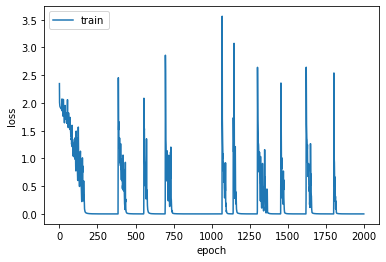

50/50 [==============================] - 0s 2ms/step - loss: 2.8633e-05 - accuracy: 1.0000
accuracy: 100.00%
one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
time: 4min 46s (started: 2021-03-27 15:44:32 +00:00)


In [ ]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)        

# 1. 데이터 준비하기

# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)

# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50, 4, 1))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 1), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))
    
# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. 모델 학습시키기
num_epochs = 2000

history = LossHistory() # 손실 이력 객체 생성

history.init()

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장

model.reset_states()
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

model.reset_states()
    
print("full song prediction : ", seq_out)

한 스텝 예측 결과와 곡 전체 예측 결과를 악보로 그려보았습니다. Stateful LSTM은 음표를 모두 맞추어서, 전체 곡 예측도 정확하게 했습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_Stateful_LSTM_song.png)

위 악보로 연주한 곡은 아래 링크에서 다운로드 받으실 수 있습니다.

* [http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f1_one_step_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f1_one_step_prediction.mp3)
* [http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f1_full_song_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f1_full_song_prediction.mp3)

### *입력 속성이 여러 개인 모델 구성*

입력 속성이 여러 개인 경우에 대해서 알아보겠습니다. 예를 들어 '기온'라는 것을 예측하기 위해서 입력으로 '기온'뿐만아니라 '습도', '기압', '풍향', '풍속' 등 다양한 속성이 있을 수 있습니다. 상태유지 LSTM 모델에서 입력형태를 batch_input_shape = (배치사이즈, 타임스텝, 속성)으로 설정하는데, 마지막 인자를 통해 속성의 개수를 지정할 수 있습니다. '나비야' 예제에서는 현재 입력값이 'c4, e4, g8'등으로 되어 있는 데, 이를 음정과 음길이로 나누어서 2개의 속성으로 입력해보겠습니다. 즉 'c4'는 '(c, 4)'로 나누어서 입력하게 되는 것입니다. 이를 위해 데이터셋 만드는 함수를 아래와 같이 수정하였습니다.

In [ ]:
def code2features(code):
    features = []
    features.append(code2scale[code[0]]/float(max_scale_value))
    features.append(code2length[code[1]])
    return features

time: 3.17 ms (started: 2021-03-27 15:49:18 +00:00)


LSTM 모델 생성 시 batch_input_shape 인자의 마지막 값이 '1'에서 '2'로 수정되었습니다.

In [ ]:
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 2), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))

time: 221 ms (started: 2021-03-27 15:49:18 +00:00)


아래 그림을 보시면 입력이 두 개로 나누어짐을 보실 수 있습니다. 이 방식은 'c8'이니 'd4'처럼 코드 자체를 학습하는 것이 아니라 음정과 음길이를 나누어서 학습하는 효과를 볼 수 있습니다. 사람이 악보를 읽을 때도 이 둘은 나누어서 인지를 하니 좀 더 사람에 가까운 학습이라고 보실 수 있습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_train_stateful_LSTM_features.png)



#### 소스코드

전체 소스는 다음과 같습니다.

one hot encoding vector size is  12
epochs : 0
50/50 - 1s - loss: 2.3451 - accuracy: 0.3000
epochs : 1
50/50 - 0s - loss: 2.0029 - accuracy: 0.3400
epochs : 2
50/50 - 0s - loss: 1.9594 - accuracy: 0.3400
epochs : 3
50/50 - 0s - loss: 1.9423 - accuracy: 0.3400
epochs : 4
50/50 - 0s - loss: 1.9323 - accuracy: 0.3400
epochs : 5
50/50 - 0s - loss: 1.9248 - accuracy: 0.3400
epochs : 6
50/50 - 0s - loss: 1.9187 - accuracy: 0.3400
epochs : 7
50/50 - 0s - loss: 1.9134 - accuracy: 0.3400
epochs : 8
50/50 - 0s - loss: 1.9085 - accuracy: 0.3400
epochs : 9
50/50 - 0s - loss: 1.9037 - accuracy: 0.3400
epochs : 10
50/50 - 0s - loss: 1.8987 - accuracy: 0.3400
epochs : 11
50/50 - 0s - loss: 1.8929 - accuracy: 0.3400
epochs : 12
50/50 - 0s - loss: 1.8862 - accuracy: 0.3600
epochs : 13
50/50 - 0s - loss: 1.8807 - accuracy: 0.3600
epochs : 14
50/50 - 0s - loss: 1.8695 - accuracy: 0.3600
epochs : 15
50/50 - 0s - loss: 1.8259 - accuracy: 0.3800
epochs : 16
50/50 - 0s - loss: 1.7802 - accuracy: 0.3400
epoch

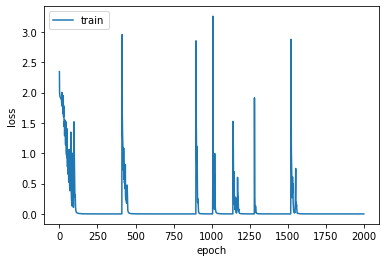

50/50 [==============================] - 0s 2ms/step - loss: 1.6689e-08 - accuracy: 1.0000
accuracy: 100.00%
one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
time: 4min 49s (started: 2021-03-27 15:49:18 +00:00)


In [ ]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset_X = []
    dataset_Y = []
    
    for i in range(len(seq)-window_size):
        
        subset = seq[i:(i+window_size+1)]
        
        for si in range(len(subset)-1):
            features = code2features(subset[si])            
            dataset_X.append(features)

        dataset_Y.append([code2idx[subset[window_size]]])
        
    return np.array(dataset_X), np.array(dataset_Y)

# 속성 변환 함수
def code2features(code):
    features = []
    features.append(code2scale[code[0]]/float(max_scale_value))
    features.append(code2length[code[1]])
    return features

# 1. 데이터 준비하기

# 코드 사전 정의

code2scale = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'a':5, 'b':6}
code2length = {'4':0, '8':1}

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

max_scale_value = 6.0
    
# 시퀀스 데이터 정의
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기

x_train, y_train = seq2dataset(seq, window_size = 4)

# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50, 4, 2))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 2), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))
    
# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. 모델 학습시키기
num_epochs = 2000

history = LossHistory() # 손실 이력 객체 생성
history.init()

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

model.reset_states()

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in

seq_in_featrues = []

for si in seq_in:
    features = code2features(si)
    seq_in_featrues.append(features)

for i in range(pred_count):
    sample_in = np.array(seq_in_featrues)
    sample_in = np.reshape(sample_in, (1, 4, 2)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    
    features = code2features(idx2code[idx])
    seq_in_featrues.append(features)
    seq_in_featrues.pop(0)

model.reset_states()
    
print("full song prediction : ", seq_out)

수행결과는 곡 전체를 정확하게 예측을 했습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_Stateful_LSTM_features_song.png)

위 악보로 연주한 곡은 아래 링크에서 다운로드 받으실 수 있습니다.

* [http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f2_one_step_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f2_one_step_prediction.mp3)
* [http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f2_full_song_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f2_full_song_prediction.mp3)

---

### 요약

익숙한 노래인 "나비야"를 가지고 순한 신경망 모델에 학습시켜봤습니다. 순항 신경망 모델 중 가장 많이 사용되는 LSTM 모델에 대해서 알아보고, 주요 인자들이 어떤 특성을 가지고 있는 지도 살펴보았습니다. 앞서 살펴본 4가지 모델에 대해서 학습 손실값을 그래프로 표시해봤습니다. 다층퍼셉트론 모델 > 기본 LSTM 모델 > 상태유지 LSTM 모델 (1개 속성) > 상태유지 LSTM 모델 (2개 속성) 순으로 더 빨리 학습되는 것을 확인할 수 있습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_loss_history.png)

## **Lab 2**

다른 노래를 이용해서, 3장에서와 같은 방식으로 <u>악보를 예측하는 모델</u>을 학습하고, 출력 결과로부터 성능을 확인합니다.

*   순환 신경망 모델의 레이어 또는 파라미터를 자유롭게 조절
*   또는, 사전 데이터를 참조하는 윈도우 범위<small>(e.g., 예제에서 20개 보고 예측)</small> 등을 자유롭게 조절

실습코드의 결과를 초과하여 성능이 향상되는 구성을 만들어보고, 출력 결과를 확인합니다.

**※ 제출방법:** 실습내용 및 출력 결과가 저장된 Colab 파일(`*.ipynb`)를 KLMS의 과제 항목에 업로드

### **<small>(참고)</small> 악보 시각화 툴 설치**

*   Abjad 공식 홈페이지: https://abjad.github.io/
  - Documantation:  http://abjad.mbrsi.org/index.html
*   LilyPond 공식 홈페이지: http://lilypond.org/development.html


#### *Abjad 파이썬 모듈 설치*


In [2]:
!pip install abjad[development,ipython]

     |████████████████████████████████| 542kB 18.8MB/s 
     |████████████████████████████████| 1.1MB 51.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 112kB 59.3MB/s 
     |████████████████████████████████| 21.6MB 1.3MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 286kB 59.1MB/s 
     |████████████████████████████████| 92kB 12.2MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 747kB 48.1MB/s 
     |████████████████████████████████| 727kB 50.4MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 245kB 57.6MB/s 
     |████████████████████████████████| 2.8MB 49.0MB/s 
     |████████████████████████████████| 245

time: 29.9 s (started: 2021-03-31 15:56:32 +00:00)


#### *LilyPond 리눅스 라이브러리 설치*


In [3]:
# 설치 스크립트 다운로드
!wget https://lilypond.org/download/binaries/linux-64/lilypond-2.22.0-1.linux-64.sh

--2021-03-31 15:57:32--  https://lilypond.org/download/binaries/linux-64/lilypond-2.22.0-1.linux-64.sh
Resolving lilypond.org (lilypond.org)... 35.206.114.173
Connecting to lilypond.org (lilypond.org)|35.206.114.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42644953 (41M) [text/x-sh]
Saving to: ‘lilypond-2.22.0-1.linux-64.sh’

lilypond-2.22.0-1.l 100%[===================>]  40.67M  74.7MB/s    in 0.5s    

2021-03-31 15:57:33 (74.7 MB/s) - ‘lilypond-2.22.0-1.linux-64.sh’ saved [42644953/42644953]

time: 814 ms (started: 2021-03-31 15:57:32 +00:00)


In [4]:
# 스크립트 실행 후, 출력 콘솔에서 Enter 입력하여 설치 진행
!sh lilypond-2.22.0-1.linux-64.sh


lilypond installer for version 2.22.0 release 1,
x86_64 build.
For a list of options, abort (^C) then do:
sh lilypond-2.22.0-1.linux-64.sh --help


You are about to install LilyPond in /usr/local/lilypond
A script in /usr/local/bin will be created as a shortcut.

Press ^C to abort, or Enter to proceed.

Making /usr/local/lilypond
Creating script /usr/local/bin/lilypond
Creating script /usr/local/bin/lilypond-wrapper.python3
Creating script /usr/local/bin/lilypond-wrapper.guile
Creating script /usr/local/bin/uninstall-lilypond
Untarring lilypond-2.22.0-1.linux-64.sh
To uninstall lilypond, run

    /usr/local/bin/uninstall-lilypond

For license and warranty information, consult

    /usr/local/lilypond/license/README

Full documentation can be found at

    http://lilypond.org/doc

time: 12.1 s (started: 2021-03-31 15:57:34 +00:00)


In [5]:
# 정상 설치여부 확인
!lilypond --version

/usr/local/lilypond/usr/bin/lilypond: /usr/local/lilypond/usr/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.21' not found (required by /usr/lib/x86_64-linux-gnu/libtcmalloc.so.4)
time: 117 ms (started: 2021-03-31 15:57:46 +00:00)


In [6]:
# 위 버전 확인 단계에서, 
#   특정 라이브러리가 없다고 하는 경우, 문제해결을 위해 심볼릭 링크 재생성
!rm /usr/local/lilypond/usr/lib/libstdc++.so.6 
!ln -s /usr/lib/x86_64-linux-gnu/libstdc++.so.6 /usr/local/lilypond/usr/lib/libstdc++.so.6 

time: 221 ms (started: 2021-03-31 15:57:46 +00:00)


#### *악보출력 기능 확인*


In [7]:
%load_ext abjadext.ipython

time: 539 ms (started: 2021-03-31 15:57:46 +00:00)


In [8]:
import abjad
seq = "c'16 f' g' a' d' g' a' b' e' a' b' c'' f' b' c'' d''16"
voice_1 = abjad.Voice(seq, name="Voice_1")
staff_1 = abjad.Staff([voice_1], name="Staff_1")
abjad.show(staff_1)

time: 1.34 s (started: 2021-03-31 15:57:49 +00:00)


### **신규 악보 및 코드 작성영역**


#### *신규 악보: 비행기 (동요)*

In [9]:
seq_lab2 = "e'8. d'16 c'8 d'8 e'8 e'8 e'4"\
            + " d'8 d'8 d' e'8 e'8 e'"\
            + " e'8. d'16 c'8 d'8 e'8 e'8 e'"\
            + " d'8 d'8 e'8. d'16 c'1"

voice_1 = abjad.Voice(seq_lab2, name="Voice_1")
staff_1 = abjad.Staff([voice_1], name="Staff_1")
abjad.show(staff_1)

time: 735 ms (started: 2021-03-31 15:57:56 +00:00)


#### *코드 작성영역*


In [10]:
code2idx = {'c1':0, 'd1':1, 'e1':2, 'f1':3, 'g1':4, 'a1':5, 'b1':6,
            'c2':7, 'd2':8, 'e2':9, 'f2':10, 'g2':11, 'a2':12, 'b2':13,
            'c4':14, 'd4':15, 'e4':16, 'f4':17, 'g4':18, 'a4':19, 'b4':20,
            'c8':21, 'd8':22, 'e8':23, 'f8':24, 'g8':25, 'a8':26, 'b8':27,
            'c16':28, 'd16':29, 'e16':30, 'f16':31, 'g16':32, 'a16':33, 'b16':34}

idx2code = {v: k for k, v in code2idx.items()}

time: 3.34 ms (started: 2021-03-31 15:57:57 +00:00)


In [11]:
import numpy as np

def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

time: 3.45 ms (started: 2021-03-31 15:58:00 +00:00)


In [15]:
seq_lab2 = ['e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'e8', 'e8', 'e8', 'e8',
       'e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e8',
       'd8', 'd8', 'e8', 'd16', 'c1']

dataset = seq2dataset(seq_lab2, window_size = 3)

print(dataset.shape)
print(dataset)

(23, 4)
[[23 29 21 22]
 [29 21 22 23]
 [21 22 23 23]
 [22 23 23 16]
 [23 23 16 22]
 [23 16 22 22]
 [16 22 22 22]
 [22 22 22 23]
 [22 22 23 23]
 [22 23 23 23]
 [23 23 23 23]
 [23 23 23 23]
 [23 23 23 29]
 [23 23 29 21]
 [23 29 21 22]
 [29 21 22 23]
 [21 22 23 23]
 [22 23 23 23]
 [23 23 23 22]
 [23 23 22 22]
 [23 22 22 23]
 [22 22 23 29]
 [22 23 29  0]]
time: 4.18 ms (started: 2021-03-31 15:58:26 +00:00)


---

### *다층 퍼셉트론 모델*

one hot encoding vector size is  30
Epoch 1/2000
3/3 - 3s - loss: 3.3600 - accuracy: 0.0435
Epoch 2/2000
3/3 - 0s - loss: 3.0812 - accuracy: 0.3043
Epoch 3/2000
3/3 - 0s - loss: 2.8438 - accuracy: 0.3043
Epoch 4/2000
3/3 - 0s - loss: 2.5958 - accuracy: 0.4783
Epoch 5/2000
3/3 - 0s - loss: 2.3784 - accuracy: 0.4783
Epoch 6/2000
3/3 - 0s - loss: 2.1466 - accuracy: 0.4783
Epoch 7/2000
3/3 - 0s - loss: 1.9680 - accuracy: 0.4783
Epoch 8/2000
3/3 - 0s - loss: 1.8114 - accuracy: 0.4783
Epoch 9/2000
3/3 - 0s - loss: 1.7105 - accuracy: 0.4783
Epoch 10/2000
3/3 - 0s - loss: 1.6548 - accuracy: 0.4783
Epoch 11/2000
3/3 - 0s - loss: 1.6082 - accuracy: 0.4783
Epoch 12/2000
3/3 - 0s - loss: 1.5662 - accuracy: 0.4783
Epoch 13/2000
3/3 - 0s - loss: 1.5346 - accuracy: 0.4783
Epoch 14/2000
3/3 - 0s - loss: 1.5112 - accuracy: 0.4783
Epoch 15/2000
3/3 - 0s - loss: 1.4956 - accuracy: 0.4783
Epoch 16/2000
3/3 - 0s - loss: 1.4775 - accuracy: 0.4783
Epoch 17/2000
3/3 - 0s - loss: 1.4624 - accuracy: 0.4783
Epoc

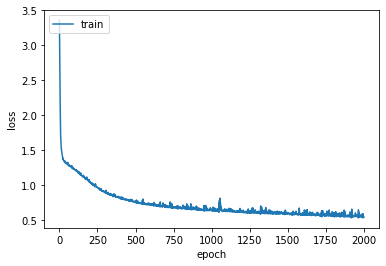

1/1 [==============================] - 0s 134ms/step - loss: 0.5375 - accuracy: 0.8261
accuracy: 82.61%
time: 36.4 s (started: 2021-03-31 16:00:20 +00:00)


In [16]:
# 0. 사용할 패키지 불러오기
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:3]
y_train = dataset[:,3]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(Dense(128, input_dim=3, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

In [17]:
len(seq_lab2)

26

time: 6 ms (started: 2021-03-31 16:00:56 +00:00)


In [21]:
# 8. 모델 사용하기
pred_count = 22 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['e8', 'd16', 'c8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['e8', 'd16', 'c8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 3)) # batch_size, feature
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

one step prediction :  ['e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e8', 'd8', 'd8', 'd8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'c8', 'd8', 'e8', 'e8', 'e8', 'e8', 'd8', 'e8', 'e8']
full song prediction :  ['e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8']
time: 686 ms (started: 2021-03-31 16:01:31 +00:00)


---

### *기본 LSTM 모델*

one hot encoding vector size is  30
Epoch 1/2000
2/2 - 30s - loss: 3.3280 - accuracy: 0.1304
Epoch 2/2000
2/2 - 0s - loss: 3.2558 - accuracy: 0.4783
Epoch 3/2000
2/2 - 0s - loss: 3.1852 - accuracy: 0.4783
Epoch 4/2000
2/2 - 0s - loss: 3.1125 - accuracy: 0.4783
Epoch 5/2000
2/2 - 0s - loss: 3.0410 - accuracy: 0.4783
Epoch 6/2000
2/2 - 0s - loss: 2.9546 - accuracy: 0.4783
Epoch 7/2000
2/2 - 0s - loss: 2.8665 - accuracy: 0.4783
Epoch 8/2000
2/2 - 0s - loss: 2.7686 - accuracy: 0.4783
Epoch 9/2000
2/2 - 0s - loss: 2.6632 - accuracy: 0.4783
Epoch 10/2000
2/2 - 0s - loss: 2.5338 - accuracy: 0.4783
Epoch 11/2000
2/2 - 0s - loss: 2.4024 - accuracy: 0.4783
Epoch 12/2000
2/2 - 0s - loss: 2.2594 - accuracy: 0.4783
Epoch 13/2000
2/2 - 0s - loss: 2.1073 - accuracy: 0.4783
Epoch 14/2000
2/2 - 0s - loss: 1.9525 - accuracy: 0.4783
Epoch 15/2000
2/2 - 0s - loss: 1.8266 - accuracy: 0.4783
Epoch 16/2000
2/2 - 0s - loss: 1.7104 - accuracy: 0.4783
Epoch 17/2000
2/2 - 0s - loss: 1.6324 - accuracy: 0.4783
Epo

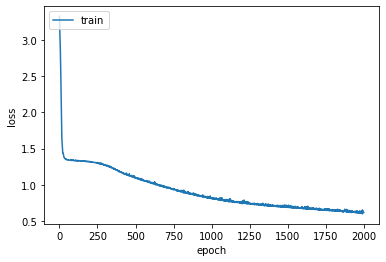

1/1 [==============================] - 0s 344ms/step - loss: 0.6203 - accuracy: 0.8261
accuracy: 82.61%
one step prediction :  ['e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e8', 'd8', 'd8', 'd8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'c8', 'd8', 'e8', 'e8', 'e8', 'e8', 'd8', 'e8', 'e8']
full song prediction :  ['e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8']
time: 58.4 s (started: 2021-03-31 16:04:55 +00:00)


In [27]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

'''
# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

# 1. 데이터 준비하기
        
# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
'''

# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:3]
y_train = dataset[:,3]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타입스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (23, 3, 1))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, input_shape = (3, 1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=14, verbose=2, callbacks=[history])

# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 8. 모델 사용하기

pred_count = 22 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['e8', 'd16', 'c8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['e8', 'd16', 'c8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 3, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

---

### *상태유지 LSTM 모델*

one hot encoding vector size is  30
epochs : 0
23/23 - 1s - loss: 2.6153 - accuracy: 0.2609
epochs : 1
23/23 - 0s - loss: 1.6592 - accuracy: 0.4783
epochs : 2
23/23 - 0s - loss: 1.5197 - accuracy: 0.4783
epochs : 3
23/23 - 0s - loss: 1.4760 - accuracy: 0.4783
epochs : 4
23/23 - 0s - loss: 1.4511 - accuracy: 0.4783
epochs : 5
23/23 - 0s - loss: 1.4344 - accuracy: 0.4783
epochs : 6
23/23 - 0s - loss: 1.4222 - accuracy: 0.4783
epochs : 7
23/23 - 0s - loss: 1.4124 - accuracy: 0.4783
epochs : 8
23/23 - 0s - loss: 1.4043 - accuracy: 0.4783
epochs : 9
23/23 - 0s - loss: 1.3975 - accuracy: 0.4783
epochs : 10
23/23 - 0s - loss: 1.3915 - accuracy: 0.4783
epochs : 11
23/23 - 0s - loss: 1.3862 - accuracy: 0.4783
epochs : 12
23/23 - 0s - loss: 1.3815 - accuracy: 0.4783
epochs : 13
23/23 - 0s - loss: 1.3770 - accuracy: 0.4783
epochs : 14
23/23 - 0s - loss: 1.3729 - accuracy: 0.5217
epochs : 15
23/23 - 0s - loss: 1.3689 - accuracy: 0.5217
epochs : 16
23/23 - 0s - loss: 1.3650 - accuracy: 0.5217
epoch

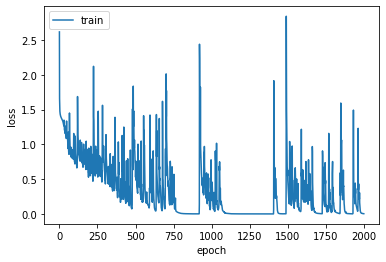

23/23 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
accuracy: 100.00%
one step prediction :  ['e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'e8', 'e8', 'e8', 'e8', 'e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e8', 'd8', 'd8', 'e8', 'd16']
full song prediction :  ['e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'e8', 'e8', 'e8', 'e8', 'e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e8', 'd8', 'd8', 'e8', 'd16']
time: 3min (started: 2021-03-31 16:05:54 +00:00)


In [28]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
'''
# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)        

# 1. 데이터 준비하기

# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
'''
# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:3]
y_train = dataset[:,3]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (23, 3, 1))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 3, 1), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))
    
# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. 모델 학습시키기
num_epochs = 2000

history = LossHistory() # 손실 이력 객체 생성

history.init()

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

# 8. 모델 사용하기

pred_count = 22 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['e8', 'd16', 'c8']
pred_out = model.predict(x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장

model.reset_states()
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['e8', 'd16', 'c8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 3, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

model.reset_states()
    
print("full song prediction : ", seq_out)

---

### *입력 속성이 여러 개인 모델 구성*

one hot encoding vector size is  30
epochs : 0
23/23 - 1s - loss: 2.5386 - accuracy: 0.3913
epochs : 1
23/23 - 0s - loss: 1.7023 - accuracy: 0.3478
epochs : 2
23/23 - 0s - loss: 1.5375 - accuracy: 0.4783
epochs : 3
23/23 - 0s - loss: 1.4783 - accuracy: 0.4783
epochs : 4
23/23 - 0s - loss: 1.4375 - accuracy: 0.4783
epochs : 5
23/23 - 0s - loss: 1.4106 - accuracy: 0.4783
epochs : 6
23/23 - 0s - loss: 1.3912 - accuracy: 0.4783
epochs : 7
23/23 - 0s - loss: 1.3750 - accuracy: 0.4783
epochs : 8
23/23 - 0s - loss: 1.3610 - accuracy: 0.4783
epochs : 9
23/23 - 0s - loss: 1.3474 - accuracy: 0.4783
epochs : 10
23/23 - 0s - loss: 1.3363 - accuracy: 0.4783
epochs : 11
23/23 - 0s - loss: 1.3191 - accuracy: 0.4783
epochs : 12
23/23 - 0s - loss: 1.3416 - accuracy: 0.4783
epochs : 13
23/23 - 0s - loss: 1.3158 - accuracy: 0.4783
epochs : 14
23/23 - 0s - loss: 1.3047 - accuracy: 0.4783
epochs : 15
23/23 - 0s - loss: 1.2948 - accuracy: 0.4783
epochs : 16
23/23 - 0s - loss: 1.2823 - accuracy: 0.4783
epoch

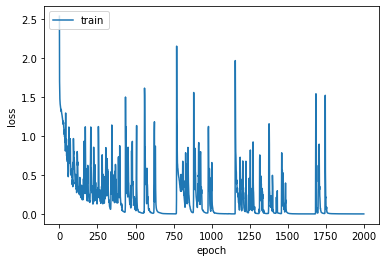

23/23 [==============================] - 0s 2ms/step - loss: 1.0776e-04 - accuracy: 1.0000
accuracy: 100.00%
one step prediction :  ['e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'e8', 'e8', 'e8', 'e8', 'e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e8', 'd8', 'd8', 'e8', 'd16']
full song prediction :  ['e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'e8', 'e8', 'e8', 'e8', 'e8', 'd16', 'c8', 'd8', 'e8', 'e8', 'e8', 'd8', 'd8', 'e8', 'd16']
time: 3min 1s (started: 2021-03-31 16:09:28 +00:00)


In [30]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset_X = []
    dataset_Y = []
    
    for i in range(len(seq)-window_size):
        
        subset = seq[i:(i+window_size+1)]
        
        for si in range(len(subset)-1):
            features = code2features(subset[si])            
            dataset_X.append(features)

        dataset_Y.append([code2idx[subset[window_size]]])
        
    return np.array(dataset_X), np.array(dataset_Y)

# 속성 변환 함수
def code2features(code):
    features = []
    features.append(code2scale[code[0]]/float(max_scale_value))
    features.append(code2length[code[1]])
    return features

# 1. 데이터 준비하기

# 코드 사전 정의

code2scale = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'a':5, 'b':6}
code2length = {'1':0, '2':1, '4':2, '8':3, '16':4}

max_scale_value = 6.0

# 2. 데이터셋 생성하기

x_train, y_train = seq2dataset(seq_lab2, window_size = 3)

# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (23, 3, 2))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 3, 2), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))
    
# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. 모델 학습시키기
num_epochs = 2000

history = LossHistory() # 손실 이력 객체 생성
history.init()

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

# 8. 모델 사용하기

pred_count = 22 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['e8', 'd16', 'c8']
pred_out = model.predict(x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

model.reset_states()

# 곡 전체 예측

seq_in = ['e8', 'd16', 'c8']
seq_out = seq_in

seq_in_featrues = []

for si in seq_in:
    features = code2features(si)
    seq_in_featrues.append(features)

for i in range(pred_count):
    sample_in = np.array(seq_in_featrues)
    sample_in = np.reshape(sample_in, (1, 3, 2)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    
    features = code2features(idx2code[idx])
    seq_in_featrues.append(features)
    seq_in_featrues.pop(0)

model.reset_states()
    
print("full song prediction : ", seq_out)